In [94]:
!pip install firebase-admin

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import requests
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import joblib
from datetime import datetime
import time
import firebase_admin
from google.colab import output
from firebase_admin import credentials, db
import math

# Tiền xử lý dữ liệu

In [96]:
# Load your data
data = pd.read_csv('merged_output.csv')
# Identify columns with object dtype
object_cols = data.select_dtypes(include=['object']).columns
# Create a LabelEncoder instance and encode object columns
label_encoder = LabelEncoder()
label_mapping = {}

print(data.tail(10).to_string()+"\n")

for col in object_cols:
	data[col] = label_encoder.fit_transform(data[col])
	label_mapping[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Save the label mappings
joblib.dump(label_mapping, 'label_mapping.joblib')

# Lựa chọn các cột số cần chuẩn hóa
numeric_columns = ["weekday", "length", "street_level", "long_node", "lat_node", "temperature_2m", "relative_humidity_2m", "cloud_cover", "season"]
data_to_normalize = data[numeric_columns]

# Chuẩn hóa các cột số
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data_to_normalize)

# Hiển thị dữ liệu sau khi chuẩn hóa
print(data.tail(10).to_string())

         _id  segment_id        date  weekday LOS   s_node_id   e_node_id  length  street_id  street_level street_type   long_node   lat_node time_x  month  temperature_2m  relative_humidity_2m  apparent_temperature  rain  weather_code  cloud_cover season
16507  32991       83729   1/22/2021        4   F  5762890465  5762890475      31  619030684             4    tertiary  106.805389  10.875074  14:00      1            31.3                    54                  34.1   0.3            51          100    dry
16508  32974       83727   1/24/2021        6   F  5762890475  5763376688     104  619030684             4    tertiary  106.805656  10.874978   3:00      1            22.9                    92                  26.8   0.0             1           40    dry
16509  32993       83729   1/24/2021        6   F  5762890465  5762890475      31  619030684             4    tertiary  106.805389  10.875074   3:00      1            22.9                    92                  26.8   0.0           

# Xây dựng mô hình và huấn luyện mô hình

In [ ]:
# Chuẩn bị dữ liệu
X = data[["weekday", "length", "street_level", "long_node", "lat_node", "temperature_2m", "relative_humidity_2m", "cloud_cover", "season"]]
y = data[['rain',"weather_code","LOS"]]  # Dự đoán lượng mưa, thời tiết, mức độ giao thông.
test_size=len(X)-500

# Chia dữ liệu
X_train, X_test = X[:test_size], X[test_size:]
y_train, y_test = y[:test_size], y[test_size:]

# Mô hình Random Forest Regression
model = RandomForestRegressor(n_estimators=5, random_state=42)
model.fit(X_train, y_train)
joblib.dump(model, 'rf_model.joblib')

y_pred = model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Hiển thị kết quả
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 172.54000533333337
R-squared: -0.21080462284826199


# Vẽ Biểu Đồ

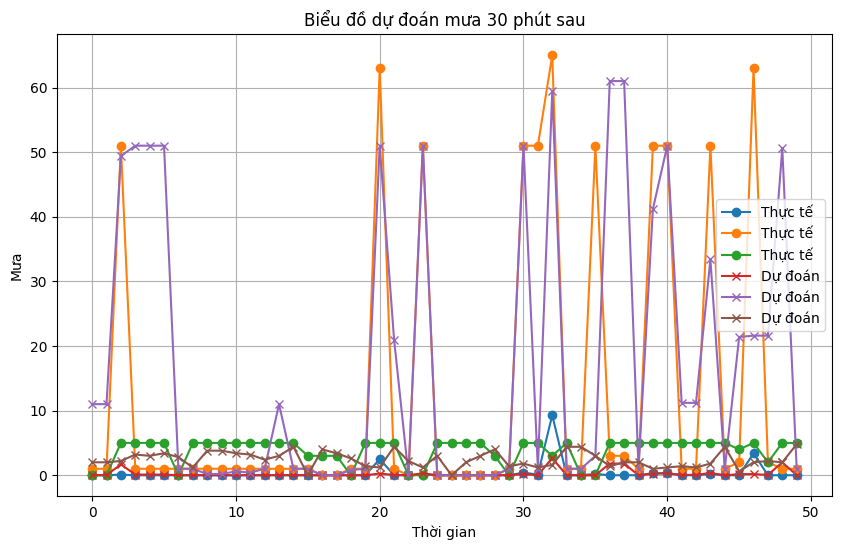

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Thực tế', marker='o')
plt.plot(y_pred, label='Dự đoán', marker='x')
plt.xlabel('Thời gian')
plt.ylabel('Mưa')
plt.title('Biểu đồ dự đoán mưa 30 phút sau')
plt.legend()
plt.grid()
plt.show()

# Xử lý dữ liệu lấy về

In [99]:
def add_hours(time_str):
    time_str = time_str.replace('Z', '')
    time = datetime.fromisoformat(time_str)
    new_time = time + timedelta(hours=5)

    new_hour = new_time.hour
    new_minute = new_time.minute
    new_second = new_time.second

    # Trả về giờ, phút và giây mới
    return int(new_hour), int(new_minute), int(new_second)
def calculate_cloud_cover(lux,maxi):
    cloud_cover = 100 - (math.log10(lux) * maxi)
    return cloud_cover

# Lấy thời gian thực
current_time = datetime.now()
current_hour = current_time.hour+7
current_weekday = current_time.weekday()

if (current_time.month >=5 and current_time.month<=10):
  current_season = 1
else:
  current_season = 0

# Vòng lặp cập nhật dữ liệu

In [ ]:
# Thiết lập kết nối tới Firebase
if not firebase_admin._apps:
    cred = credentials.Certificate("serviceAccountKey.json")
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://weather-forecast-13899-default-rtdb.asia-southeast1.firebasedatabase.app/'
    })
ref = db.reference()

# Dự đoán nhiệt độ 30 phút sau trên tập kiểm tra
while True:
  # Các thông tin cần thiết
  channel_id = '2332757'
  fields=[]
  url = f'https://api.thingspeak.com/channels/{channel_id}/feeds.json?results=5'
  # Lấy dữ liệu từ Thingspeak
  create_at=''
  response = requests.get(url)
  if response.status_code == 200:
      res = response.json()
      fields = []
      feed=res['feeds'][0]
      for key in feed:
        if key=='created_at':
          create_at=feed[key]
        if key.startswith('field'):
          fields.append(feed[key])
  else:
    time.sleep(15)
    continue
  # Sử dụng hàm
  new_hour, new_minute, new_second = add_hours(create_at)

  if (new_hour>7 and new_hour<18):
    cloud_cover_val=calculate_cloud_cover(float(fields[3]),35)
  else:
    cloud_cover_val=calculate_cloud_cover(float(fields[3]),55)
  # Tạo dữ liệu mới DataFrame
  new_data = np.array([current_weekday, 104, 2, 106.70, 10.73, float(fields[0]), float(fields[1]), cloud_cover_val, current_season]).reshape(1, -1)
  data_new_data = pd.DataFrame(new_data, columns=["weekday", "length", "street_level", "long_node", "lat_node", "temperature_2m", "relative_humidity_2m", "cloud_cover", "season"])
  res_data= scaler.transform(data_new_data)
  data_res_data = pd.DataFrame(res_data, columns=["weekday", "length", "street_level", "long_node", "lat_node", "temperature_2m", "relative_humidity_2m", "cloud_cover", "season"])

  # pred model
  X_test=data_res_data
  loaded_model = joblib.load('rf_model.joblib')
  y_pred = loaded_model.predict(X_test)



  # Replace this line with the actual definition and calculation of y_pred
  data = {
      'rain_pred': y_pred[0][0],
      "weather_code": y_pred[0][1],
      'los': y_pred[0][2],
      'temp': float(fields[0]),
      'hum': float(fields[1]),
      'rain': 0 if (float(fields[2]) == 1) else 1,
      'light': float(fields[3]),
      'ppm': float(fields[4]),
  }

  # Push new data to Firebase, generating a unique key
  specific_key = "weather_data"
  ref.child(specific_key).set(data)
  output.clear()
  print(data_res_data.to_string()+'\n')
  print(data)
  print("Data added successfully with key:",specific_key ,"\n")

  time.sleep(15)


   weekday    length  street_level  long_node  lat_node  temperature_2m  relative_humidity_2m  cloud_cover  season
0      0.0  0.102868      0.333333   0.492103  0.252309        0.507353               0.78125     0.727647     0.0

{'rain_pred': 0.08, 'weather_code': 41.2, 'los': 0.0, 'temp': 27.1, 'hum': 86.0, 'rain': 1, 'light': 6.0, 'ppm': 0.24}
Data added successfully with key: weather_data 

